In [6]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
from tqdm import tqdm
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [7]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [8]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [9]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
def add_noise(w):
    ret = w + tf.where(tf.math.abs(w) > 0.1, tf.random.normal([len(w)], mean = 0, stddev = tf.math.reduce_std(w)), 0)
    return ret
    
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: add_noise(x[i*stride:i*stride+size]), 
                     tf.repeat(tf.range((length-size)//stride+1), 1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label

In [12]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(256)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(256)
    return output_ds

In [17]:
size_sec = 30
stride_sec = 1

In [9]:
train_ds = preprocess_dataset(tf.random.shuffle(tf.repeat(train_files, 200)))
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [10]:
# for spectrogram, y in train_ds.take(1):
#     input_shape = spectrogram.shape
#     print(input_shape)
#     print(y)


In [11]:
input_shape = (30, 257, 1)

In [12]:
batch_size = 256
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [265]:
print('Input shape:', input_shape)
def reluActivationMax(x):
    return tf.keras.activations.relu(x, max_value=30)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0],input_shape[1])),
    norm_layer,
#     layers.Conv2D(16,16, activation = 'relu',  padding='same'), 
#     layers.Conv2D(8,8, activation = 'relu',  padding='same'), 
#     layers.MaxPooling2D(),
#     layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'), layers.Dropout(0.5), layers.BatchNormalization(),
#     layers.Reshape((15 * 128, 128)),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'), layers.Dropout(0.5), layers.BatchNormalization(),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'), layers.Dropout(0.5), layers.BatchNormalization(),
    layers.LSTM(16, activation='relu', kernel_initializer='he_normal', return_sequences=True), layers.Dropout(0.5), layers.BatchNormalization(),
    layers.LSTM(8, activation='relu', kernel_initializer='he_normal'), layers.Dropout(0.5), layers.BatchNormalization(),
#     layers.Dense(4, activation='relu', kernel_initializer='he_normal'), layers.Dropout(0.5),layers.BatchNormalization(),
    layers.Dense(1, activation='relu', kernel_initializer='he_normal')
])

model.summary()

Input shape: (30, 257, 1)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 30, 257)           0         
_________________________________________________________________
normalization_8 (Normalizati (None, 30, 257)           3         
_________________________________________________________________
dense_35 (Dense)             (None, 30, 128)           33024     
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 128)           512       
_________________________________________________________________
dense_36 (Dense)             (None, 30, 64)            8256      
_________________________________________________________________
dropout_44 (Dropout)        

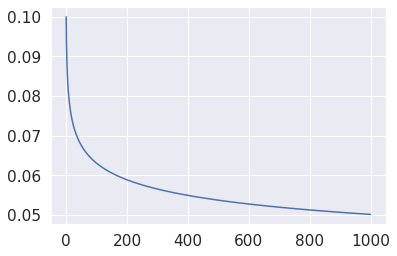

In [266]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0),
    loss= 'mse',#'mean_absolute_percentage_error',
    metrics='mean_absolute_percentage_error'
)
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.1)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=0.01))
tb_callback = tf.keras.callbacks.TensorBoard('/logs/fit', update_freq=1)

scheduler = SquareRootScheduler(lr=0.1)
plt.plot(tf.range(1000), [scheduler(t) for t in range(1000)])

In [267]:
EPOCHS = 1000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[es_callback, lr_callback, tb_callback],
    verbose = 2
)

Epoch 1/1000
59/59 - 6s - loss: 447.5518 - mean_absolute_percentage_error: 87.7323 - val_loss: 277.4589 - val_mean_absolute_percentage_error: 66.4381
Epoch 2/1000
59/59 - 3s - loss: 193.5517 - mean_absolute_percentage_error: 60.2455 - val_loss: 137.3275 - val_mean_absolute_percentage_error: 49.3615
Epoch 3/1000
59/59 - 3s - loss: 65.4388 - mean_absolute_percentage_error: 57.9406 - val_loss: 54.0241 - val_mean_absolute_percentage_error: 35.3113
Epoch 4/1000
59/59 - 3s - loss: 55.7880 - mean_absolute_percentage_error: 56.4657 - val_loss: 43.5293 - val_mean_absolute_percentage_error: 28.5864
Epoch 5/1000
59/59 - 3s - loss: 53.3110 - mean_absolute_percentage_error: 53.3039 - val_loss: 57.7276 - val_mean_absolute_percentage_error: 33.1834
Epoch 6/1000
59/59 - 3s - loss: 47.7031 - mean_absolute_percentage_error: 44.6686 - val_loss: 58.6634 - val_mean_absolute_percentage_error: 33.0508
Epoch 7/1000
59/59 - 3s - loss: 43.2861 - mean_absolute_percentage_error: 40.2421 - val_loss: 58.6242 - val_

59/59 - 3s - loss: 13.9555 - mean_absolute_percentage_error: 22.9009 - val_loss: 47.2473 - val_mean_absolute_percentage_error: 28.8770
Epoch 57/1000
59/59 - 3s - loss: 13.1098 - mean_absolute_percentage_error: 21.6765 - val_loss: 34.3772 - val_mean_absolute_percentage_error: 25.7635
Epoch 58/1000
59/59 - 3s - loss: 14.3477 - mean_absolute_percentage_error: 23.4513 - val_loss: 36.4850 - val_mean_absolute_percentage_error: 27.0103
Epoch 59/1000
59/59 - 3s - loss: 13.2925 - mean_absolute_percentage_error: 21.3464 - val_loss: 37.2796 - val_mean_absolute_percentage_error: 26.0635
Epoch 60/1000
59/59 - 3s - loss: 13.1284 - mean_absolute_percentage_error: 21.6635 - val_loss: 36.7877 - val_mean_absolute_percentage_error: 26.0230
Epoch 61/1000
59/59 - 3s - loss: 13.6113 - mean_absolute_percentage_error: 23.1956 - val_loss: 38.5824 - val_mean_absolute_percentage_error: 27.0104
Epoch 62/1000
59/59 - 3s - loss: 13.0465 - mean_absolute_percentage_error: 22.0303 - val_loss: 41.1310 - val_mean_absolu

59/59 - 3s - loss: 12.0357 - mean_absolute_percentage_error: 19.4926 - val_loss: 54.2138 - val_mean_absolute_percentage_error: 30.9442
Epoch 112/1000
59/59 - 3s - loss: 11.9731 - mean_absolute_percentage_error: 20.1127 - val_loss: 36.9699 - val_mean_absolute_percentage_error: 25.4529
Epoch 113/1000
59/59 - 3s - loss: 11.8722 - mean_absolute_percentage_error: 19.2056 - val_loss: 33.5078 - val_mean_absolute_percentage_error: 24.8846
Epoch 114/1000
59/59 - 3s - loss: 12.0418 - mean_absolute_percentage_error: 18.9076 - val_loss: 38.8979 - val_mean_absolute_percentage_error: 25.2456
Epoch 115/1000
59/59 - 3s - loss: 12.1554 - mean_absolute_percentage_error: 19.8922 - val_loss: 40.7384 - val_mean_absolute_percentage_error: 25.3974
Epoch 116/1000
59/59 - 3s - loss: 11.8697 - mean_absolute_percentage_error: 19.7896 - val_loss: 43.6741 - val_mean_absolute_percentage_error: 26.4375
Epoch 117/1000
59/59 - 3s - loss: 11.8728 - mean_absolute_percentage_error: 20.4479 - val_loss: 39.0464 - val_mean_

Epoch 166/1000
59/59 - 3s - loss: 11.6380 - mean_absolute_percentage_error: 19.1724 - val_loss: 54.6955 - val_mean_absolute_percentage_error: 28.1595
Epoch 167/1000
59/59 - 3s - loss: 11.7977 - mean_absolute_percentage_error: 19.2390 - val_loss: 56.8798 - val_mean_absolute_percentage_error: 29.4145
Epoch 168/1000
59/59 - 3s - loss: 11.6384 - mean_absolute_percentage_error: 19.6093 - val_loss: 51.3226 - val_mean_absolute_percentage_error: 26.9934
Epoch 169/1000
59/59 - 3s - loss: 11.8226 - mean_absolute_percentage_error: 20.1017 - val_loss: 50.5043 - val_mean_absolute_percentage_error: 26.6603
Epoch 170/1000
59/59 - 3s - loss: 11.8241 - mean_absolute_percentage_error: 20.1769 - val_loss: 48.3831 - val_mean_absolute_percentage_error: 26.7601
Epoch 171/1000
59/59 - 3s - loss: 11.7976 - mean_absolute_percentage_error: 20.0088 - val_loss: 47.9785 - val_mean_absolute_percentage_error: 25.7210
Epoch 172/1000
59/59 - 3s - loss: 11.2073 - mean_absolute_percentage_error: 18.5820 - val_loss: 62.0

Epoch 221/1000
59/59 - 3s - loss: 11.1720 - mean_absolute_percentage_error: 18.7646 - val_loss: 26.8356 - val_mean_absolute_percentage_error: 22.0531
Epoch 222/1000
59/59 - 3s - loss: 11.4007 - mean_absolute_percentage_error: 19.0992 - val_loss: 42.0525 - val_mean_absolute_percentage_error: 25.2829
Epoch 223/1000
59/59 - 3s - loss: 10.8592 - mean_absolute_percentage_error: 17.8730 - val_loss: 28.0022 - val_mean_absolute_percentage_error: 22.1182
Epoch 224/1000
59/59 - 3s - loss: 11.1187 - mean_absolute_percentage_error: 18.2856 - val_loss: 31.8780 - val_mean_absolute_percentage_error: 23.7069
Epoch 225/1000
59/59 - 3s - loss: 11.0103 - mean_absolute_percentage_error: 17.8352 - val_loss: 36.1181 - val_mean_absolute_percentage_error: 25.0305
Epoch 226/1000
59/59 - 3s - loss: 11.0489 - mean_absolute_percentage_error: 18.4569 - val_loss: 38.2341 - val_mean_absolute_percentage_error: 26.4804
Epoch 227/1000
59/59 - 3s - loss: 10.8866 - mean_absolute_percentage_error: 18.6703 - val_loss: 33.9

Epoch 276/1000
59/59 - 3s - loss: 11.0126 - mean_absolute_percentage_error: 18.6647 - val_loss: 50.2318 - val_mean_absolute_percentage_error: 27.3969
Epoch 277/1000
59/59 - 3s - loss: 11.2635 - mean_absolute_percentage_error: 18.1273 - val_loss: 39.9197 - val_mean_absolute_percentage_error: 26.0928
Epoch 278/1000
59/59 - 3s - loss: 11.1844 - mean_absolute_percentage_error: 18.6724 - val_loss: 40.0955 - val_mean_absolute_percentage_error: 25.2216
Epoch 279/1000
59/59 - 3s - loss: 10.9696 - mean_absolute_percentage_error: 18.3115 - val_loss: 51.3940 - val_mean_absolute_percentage_error: 29.9133
Epoch 280/1000
59/59 - 3s - loss: 11.1439 - mean_absolute_percentage_error: 18.6015 - val_loss: 48.6716 - val_mean_absolute_percentage_error: 27.3570
Epoch 281/1000
59/59 - 3s - loss: 11.2562 - mean_absolute_percentage_error: 18.6709 - val_loss: 42.3133 - val_mean_absolute_percentage_error: 24.0140
Epoch 282/1000
59/59 - 3s - loss: 10.6784 - mean_absolute_percentage_error: 17.6897 - val_loss: 35.0

Epoch 331/1000
59/59 - 3s - loss: 11.0197 - mean_absolute_percentage_error: 18.0487 - val_loss: 33.7504 - val_mean_absolute_percentage_error: 24.2338
Epoch 332/1000
59/59 - 3s - loss: 10.8805 - mean_absolute_percentage_error: 18.0187 - val_loss: 23.2911 - val_mean_absolute_percentage_error: 20.8791
Epoch 333/1000
59/59 - 3s - loss: 10.5801 - mean_absolute_percentage_error: 17.6181 - val_loss: 25.1871 - val_mean_absolute_percentage_error: 21.6473
Epoch 334/1000
59/59 - 3s - loss: 11.0037 - mean_absolute_percentage_error: 18.5112 - val_loss: 24.7862 - val_mean_absolute_percentage_error: 20.6099
Epoch 335/1000
59/59 - 3s - loss: 10.7196 - mean_absolute_percentage_error: 17.8539 - val_loss: 30.0124 - val_mean_absolute_percentage_error: 22.2940
Epoch 336/1000
59/59 - 3s - loss: 11.0368 - mean_absolute_percentage_error: 18.5842 - val_loss: 44.7578 - val_mean_absolute_percentage_error: 25.1290
Epoch 337/1000
59/59 - 3s - loss: 10.7943 - mean_absolute_percentage_error: 17.9977 - val_loss: 35.9

Epoch 386/1000
59/59 - 3s - loss: 10.6201 - mean_absolute_percentage_error: 18.0750 - val_loss: 38.7852 - val_mean_absolute_percentage_error: 25.4542
Epoch 387/1000
59/59 - 3s - loss: 10.7963 - mean_absolute_percentage_error: 17.9371 - val_loss: 26.9722 - val_mean_absolute_percentage_error: 22.1720
Epoch 388/1000
59/59 - 3s - loss: 11.0360 - mean_absolute_percentage_error: 18.6505 - val_loss: 30.6439 - val_mean_absolute_percentage_error: 22.2420
Epoch 389/1000
59/59 - 3s - loss: 10.9770 - mean_absolute_percentage_error: 17.7645 - val_loss: 31.0253 - val_mean_absolute_percentage_error: 22.1855
Epoch 390/1000
59/59 - 3s - loss: 11.0453 - mean_absolute_percentage_error: 17.6414 - val_loss: 40.3453 - val_mean_absolute_percentage_error: 26.1052
Epoch 391/1000
59/59 - 3s - loss: 11.0105 - mean_absolute_percentage_error: 18.7822 - val_loss: 31.0460 - val_mean_absolute_percentage_error: 22.6936
Epoch 392/1000
59/59 - 3s - loss: 10.7420 - mean_absolute_percentage_error: 17.7892 - val_loss: 41.1

Epoch 441/1000
59/59 - 3s - loss: 10.7910 - mean_absolute_percentage_error: 17.4648 - val_loss: 51.5926 - val_mean_absolute_percentage_error: 27.5930
Epoch 442/1000
59/59 - 3s - loss: 10.8884 - mean_absolute_percentage_error: 18.5329 - val_loss: 84.1700 - val_mean_absolute_percentage_error: 32.5147
Epoch 443/1000
59/59 - 3s - loss: 10.5590 - mean_absolute_percentage_error: 17.8249 - val_loss: 59.7390 - val_mean_absolute_percentage_error: 27.6786
Epoch 444/1000
59/59 - 3s - loss: 11.0379 - mean_absolute_percentage_error: 18.9953 - val_loss: 79.5079 - val_mean_absolute_percentage_error: 28.9656
Epoch 445/1000
59/59 - 3s - loss: 11.0617 - mean_absolute_percentage_error: 18.2436 - val_loss: 46.2020 - val_mean_absolute_percentage_error: 25.4393
Epoch 446/1000
59/59 - 3s - loss: 10.6617 - mean_absolute_percentage_error: 17.6856 - val_loss: 76.8905 - val_mean_absolute_percentage_error: 31.3170
Epoch 447/1000
59/59 - 3s - loss: 10.5693 - mean_absolute_percentage_error: 17.2426 - val_loss: 53.3

Epoch 496/1000
59/59 - 3s - loss: 10.7295 - mean_absolute_percentage_error: 17.5045 - val_loss: 67.0798 - val_mean_absolute_percentage_error: 30.0067
Epoch 497/1000
59/59 - 3s - loss: 10.6421 - mean_absolute_percentage_error: 17.7039 - val_loss: 51.0599 - val_mean_absolute_percentage_error: 26.7240
Epoch 498/1000
59/59 - 3s - loss: 10.6346 - mean_absolute_percentage_error: 17.3545 - val_loss: 49.4908 - val_mean_absolute_percentage_error: 25.3899
Epoch 499/1000
59/59 - 3s - loss: 10.9103 - mean_absolute_percentage_error: 19.2823 - val_loss: 53.9263 - val_mean_absolute_percentage_error: 26.8710
Epoch 500/1000
59/59 - 3s - loss: 10.5660 - mean_absolute_percentage_error: 17.3140 - val_loss: 42.3307 - val_mean_absolute_percentage_error: 24.4537
Epoch 501/1000
59/59 - 3s - loss: 11.0293 - mean_absolute_percentage_error: 18.3160 - val_loss: 56.7992 - val_mean_absolute_percentage_error: 27.2685
Epoch 502/1000
59/59 - 3s - loss: 10.4913 - mean_absolute_percentage_error: 17.4666 - val_loss: 45.1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


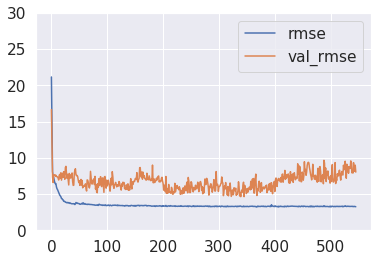

In [269]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['loss']), np.sqrt(metrics['val_loss']))
plt.legend(['rmse', 'val_rmse'])
axes = plt.axes()
axes.set_ylim([0, 30])
plt.show()

In [270]:
# weights = model.get_weights()
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0),
#     loss= 'mean_absolute_percentage_error',
#     metrics='mse'
# )
# model.set_weights(weights)
# EPOCHS = 200
# history = model.fit(
#     train_ds_b, 
#     validation_data=val_ds_b,  
#     epochs=EPOCHS,
#     callbacks=[es_callback, lr_callback, tb_callback],
#     verbose = 2
# )

In [271]:
# metrics = history.history
# plt.plot(history.epoch, np.sqrt(metrics['loss']), np.sqrt(metrics['val_loss']))
# plt.legend(['rmse', 'val_rmse'])
# axes = plt.axes()
# axes.set_ylim([0, 30])
# plt.show()

In [272]:
np.sqrt(model.evaluate(val_ds.batch(batch_size))) 

1/1 [==============================] - 0s 91ms/step - loss: 21.5273 - mean_absolute_percentage_error: 19.4872


array([4.63974987, 4.41443496])

In [273]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

1/1 [==============================] - 0s 92ms/step - loss: 45.4334 - mean_absolute_percentage_error: 26.8443


array([6.74043189, 5.18114422])

In [15]:
def window_eval(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data_eval(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
        
    rolling_waveform_tensors = window_eval(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label/30

In [13]:
# model = tf.keras.models.load_model('saved_model/michael/rl_lstm_wn_0314')
# model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 30, 257)           0         
_________________________________________________________________
normalization_8 (Normalizati (None, 30, 257)           3         
_________________________________________________________________
dense_35 (Dense)             (None, 30, 128)           33024     
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 128)           512       
_________________________________________________________________
dense_36 (Dense)             (None, 30, 64)            8256      
_________________________________________________________________
dropout_44 (Dropout)         (None, 30, 64)           

In [276]:
# model.set_weights(weights)

In [18]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data_eval(file)[0]).mean()  
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data_eval(file)[0]).mean() 
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data_eval(file)[0]).mean() 
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [19]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,6.025420
1,train,5.733340
2,val,7.144976


In [20]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,6.229499
1,male,5.720845


In [21]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

6.008748657564505

In [22]:
meta.predict.describe()

count    108.000000
mean      23.283673
std        2.841247
min       14.805541
25%       21.718843
50%       23.705966
75%       25.465997
max       27.102104
Name: predict, dtype: float64

In [23]:
meta.sort_values('predict')

,index,ID,Age,Gender,MMSE,Group,split,predict,predict_group
102,48,S149,70,female,12,cd,train,14.805541,cd
77,23,S111,66,female,1,cd,train,15.348806,cd
63,9,S090,59,male,8,cd,train,16.806601,cd
76,22,S110,73,female,16,cd,train,17.303350,cd
66,12,S094,64,female,17,cd,train,17.573383,cd
...,...,...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,val,26.785460,cc
49,49,S071,74,male,29,cc,train,26.837410,cc
40,40,S058,69,female,30,cc,test,26.856350,cc
32,32,S041,57,female,30,cc,val,26.911125,cc


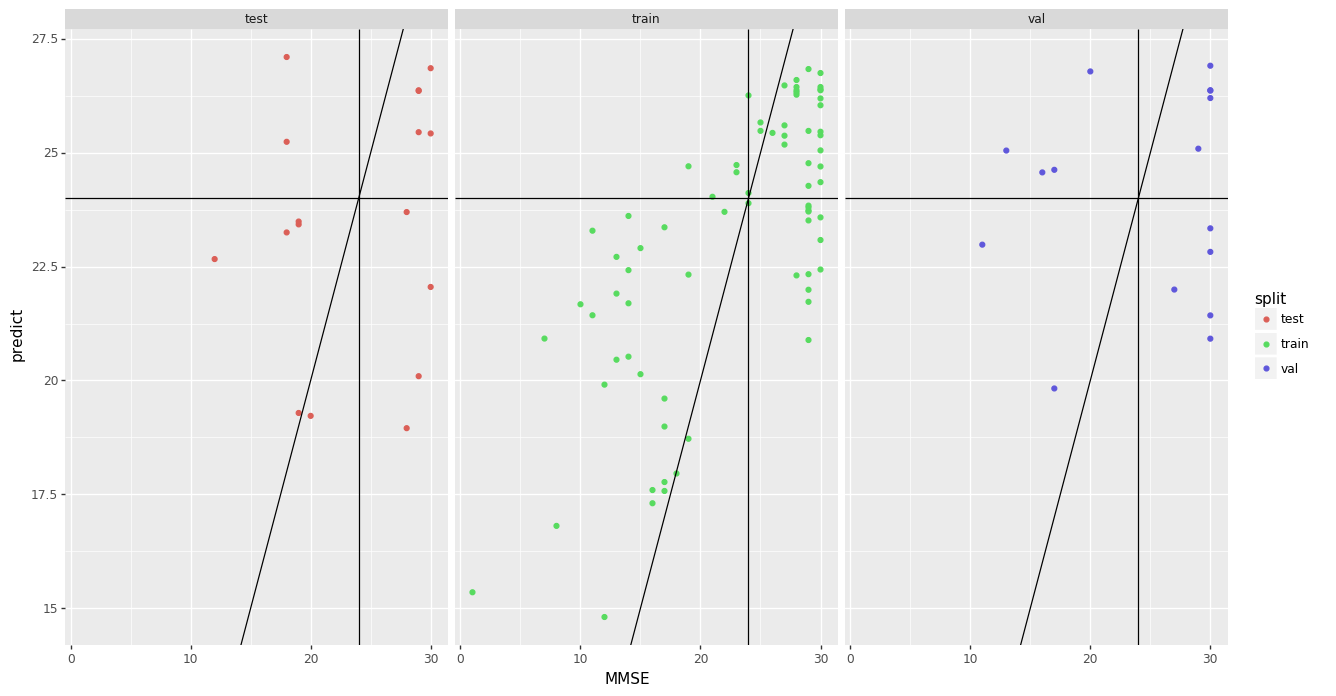

<ggplot: (8741297009742)>

In [302]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

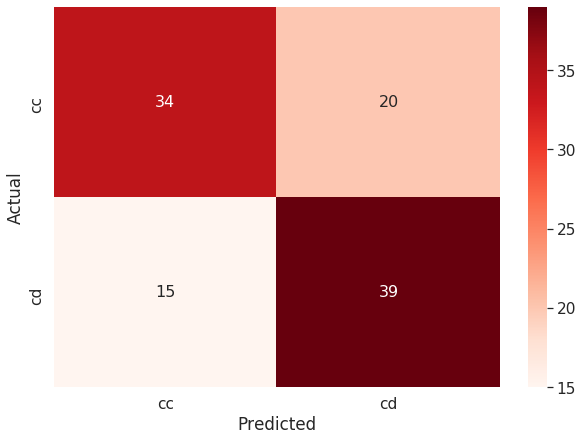

In [303]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [304]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          cc       0.69      0.63      0.66        54
          cd       0.66      0.72      0.69        54

    accuracy                           0.68       108
   macro avg       0.68      0.68      0.68       108
weighted avg       0.68      0.68      0.68       108



In [305]:
# model.save('saved_model/michael/rl_lstm_wn_0314')

In [306]:
ls saved_model/michael

20210304/  eGeMAPS/  rl_lstm_wn/  rl_lstm_wn_0314/


In [24]:
meta.to_csv(path_or_buf = '4-RollingWindow+LSTM+WN.csv', index=True)

# Pitts Corpus

In [307]:
data_path_pitt = '/tf/data/dementia/English/Pitt/'
files_pitt = tf.io.gfile.glob(data_path_pitt + 'Control/cookie/*.wav') + \
             tf.io.gfile.glob(data_path_pitt + 'Dementia/cookie/*.wav')

In [308]:
def model_inference(filepath):

    import tensorflow as tf
    import numpy as np
    import json
    import requests	
    import os
    from datetime import datetime
    
    input_file = filepath
    if not filepath.lower().endswith(".wav"):
#         tmp_name = "tmp-"+datetime.now().strftime("%Y%m%d-%H%M%S")
        input_file = input_file.split('.mp3')[0] + '.wav'
        cmd = "ffmpeg -i " + filepath + " " + input_file
        os.system(cmd)
    
    audio_binary = tf.io.read_file(input_file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    if audio.shape[1] > 1:
        audio = tf.reshape(audio[:, 0], (audio.shape[0],1))

    waveform = tf.squeeze(audio, axis=-1)    
    rolling_waveform_tensors = window_eval(waveform, size=_*30, stride=_*1)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
    rolling_spectrograms = rolling_spectrograms.numpy().tolist()
    
    predictions = model.predict(rolling_spectrograms)
    results = [x[0] for x in predictions]
    result = sum(results)/len(results) 

#     os.system('rm ' + input_file)
    return result, results

In [309]:
meta_pitt = pd.DataFrame(columns= ['file', 'ID', 'Group', 'MMSE', 'predict', 'predict_group', 'predicts'])
for file in tqdm(files_pitt):
#     print(file)
    ID = file.split('/')[-1].split('.')[0]
    Group = file.split('/')[6]
    cha = pd.read_fwf(data_path_pitt + 'Pitt/' + Group + '/cookie/' + ID + '.cha')  
    cha_id = [x for x in cha['@UTF8'] if str.startswith(x, '@ID:')][0]
    
    if (cha_id.split('|')[-3] == ''):
        MMSE = np.NaN
    else:
        MMSE = int(cha_id.split('|')[-3])
        
    predict, predicts = model_inference(file)
    if (predict < 24):
        predict_group = 'Dementia'
    else:
        predict_group = 'Control'
    meta_pitt = meta_pitt.append(pd.DataFrame([[file, ID, Group, MMSE, predict, predict_group, predicts]], 
                                  columns = list(meta_pitt.columns)))









  0%|          | 0/552 [00:00<?, ?it/s]







  0%|          | 1/552 [00:00<04:37,  1.99it/s]







  0%|          | 2/552 [00:01<06:22,  1.44it/s]







  1%|          | 4/552 [00:05<09:03,  1.01it/s]







  1%|          | 5/552 [00:07<12:06,  1.33s/it]







  1%|          | 6/552 [00:07<10:13,  1.12s/it]







  1%|▏         | 7/552 [00:10<13:29,  1.48s/it]







  1%|▏         | 8/552 [00:11<13:04,  1.44s/it]







  2%|▏         | 9/552 [00:11<09:25,  1.04s/it]







  2%|▏         | 10/552 [00:14<14:03,  1.56s/it]







  2%|▏         | 11/552 [00:15<11:52,  1.32s/it]







  2%|▏         | 12/552 [00:17<13:42,  1.52s/it]







  2%|▏         | 13/552 [00:19<16:39,  1.85s/it]







  3%|▎         | 14/552 [00:20<14:51,  1.66s/it]







  3%|▎         | 15/552 [00:22<15:27,  1.73s/it]







  3%|▎         | 17/552 [00:23<12:18,  1.38s/it]







  3%|▎         | 18/552 [00:27<17:28,  1.96s/it]







  3%|▎         | 19/552 [00:27<12:56,  1.46s/it]







 

 37%|███▋      | 205/552 [05:16<07:18,  1.26s/it]







 37%|███▋      | 206/552 [05:17<07:12,  1.25s/it]







 38%|███▊      | 207/552 [05:18<06:54,  1.20s/it]







 38%|███▊      | 208/552 [05:21<08:58,  1.57s/it]







 38%|███▊      | 209/552 [05:23<10:15,  1.80s/it]







 38%|███▊      | 210/552 [05:23<07:35,  1.33s/it]







 38%|███▊      | 211/552 [05:25<07:50,  1.38s/it]







 38%|███▊      | 212/552 [05:29<12:02,  2.13s/it]







 39%|███▊      | 213/552 [05:29<09:45,  1.73s/it]







 39%|███▉      | 214/552 [05:34<14:44,  2.62s/it]







 39%|███▉      | 215/552 [05:34<10:38,  1.90s/it]







 39%|███▉      | 216/552 [05:37<11:25,  2.04s/it]







 39%|███▉      | 217/552 [05:38<10:13,  1.83s/it]







 39%|███▉      | 218/552 [05:39<09:01,  1.62s/it]







 40%|███▉      | 219/552 [05:40<07:44,  1.40s/it]







 40%|███▉      | 220/552 [05:41<07:31,  1.36s/it]







 40%|████      | 221/552 [05:42<06:41,  1.21s/it]







 40%|████      | 222/552 [05:44

 74%|███████▎  | 407/552 [11:59<03:03,  1.26s/it]







 74%|███████▍  | 408/552 [12:05<06:24,  2.67s/it]







 74%|███████▍  | 409/552 [12:05<04:44,  1.99s/it]







 74%|███████▍  | 410/552 [12:07<04:55,  2.08s/it]







 74%|███████▍  | 411/552 [12:08<03:57,  1.69s/it]







 75%|███████▍  | 412/552 [12:10<03:57,  1.70s/it]







 75%|███████▍  | 413/552 [12:12<04:28,  1.93s/it]







 75%|███████▌  | 414/552 [12:18<06:59,  3.04s/it]







 75%|███████▌  | 415/552 [12:20<06:35,  2.89s/it]







 75%|███████▌  | 416/552 [12:21<04:52,  2.15s/it]







 76%|███████▌  | 417/552 [12:22<03:55,  1.75s/it]







 76%|███████▌  | 418/552 [12:31<08:40,  3.89s/it]







 76%|███████▌  | 419/552 [12:33<07:23,  3.33s/it]







 76%|███████▌  | 420/552 [12:36<07:24,  3.37s/it]







 76%|███████▋  | 421/552 [12:38<06:38,  3.05s/it]







 76%|███████▋  | 422/552 [12:42<07:10,  3.31s/it]







 77%|███████▋  | 423/552 [12:44<06:07,  2.85s/it]







 77%|███████▋  | 424/552 [12:46

In [310]:
meta_pitt['predict'] = [x if x < 30 else 30 for x in meta_pitt.predict]
meta_pitt['predict_group'] = ['Control' if x >= 24 else 'Dementia' for x in meta_pitt.predict]

In [311]:
meta_pitt['predict_min'] = [min(x) for x in meta_pitt.predicts]
meta_pitt['predict_group_min'] = ['Control' if x >= 24 else 'Dementia' for x in meta_pitt.predict_min]

In [312]:
meta_pitt_eval = meta_pitt[meta_pitt.MMSE.notna()]

In [313]:
meta_pitt.shape

(552, 9)

In [314]:
meta_pitt_eval.shape

(457, 9)

In [315]:
meta_pitt_eval.head()

,file,ID,Group,MMSE,predict,predict_group,predicts,predict_min,predict_group_min
0,/tf/data/dementia/English/Pitt/Control/cookie/...,255-1,Control,28,26.444284,Control,"[27.041546, 27.325848, 27.1691, 27.000807, 26....",23.574951,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,056-3,Control,29,25.113256,Control,"[27.079748, 27.240667, 27.03106, 26.961666, 26...",18.911139,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,139-3,Control,30,23.186214,Dementia,[23.186214],23.186214,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,210-2,Control,29,26.462302,Control,"[26.219908, 26.179398, 26.199232, 26.265936, 2...",25.900721,Control
0,/tf/data/dementia/English/Pitt/Control/cookie/...,109-1,Control,30,24.406082,Control,"[22.90908, 19.194954, 19.457952, 19.942902, 21...",17.206993,Dementia


In [316]:
meta_pitt_eval.predict.describe()

count    457.000000
mean      23.766369
std        2.880452
min       11.406401
25%       22.321889
50%       24.749089
75%       26.077358
max       27.306942
Name: predict, dtype: float64

In [317]:
np.sqrt(mean_squared_error(meta_pitt_eval['MMSE'], meta_pitt_eval['predict'] ))

6.2860519836257875

In [318]:
meta_pitt.to_csv(path_or_buf = '4-RollingWindow+LSTM+WN-pitt.csv', index=True)

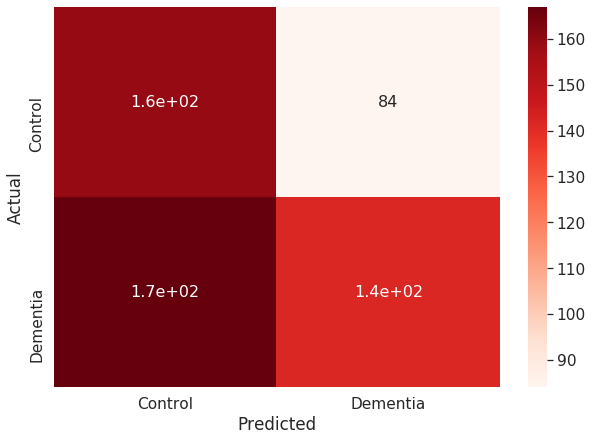

In [319]:
y_true = meta_pitt.Group
y_pred = meta_pitt.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16})# font size

In [320]:
df_cm

Predicted,Control,Dementia
Actual,,
Control,159,84
Dementia,167,142


In [321]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     Control       0.49      0.65      0.56       243
    Dementia       0.63      0.46      0.53       309

    accuracy                           0.55       552
   macro avg       0.56      0.56      0.54       552
weighted avg       0.57      0.55      0.54       552



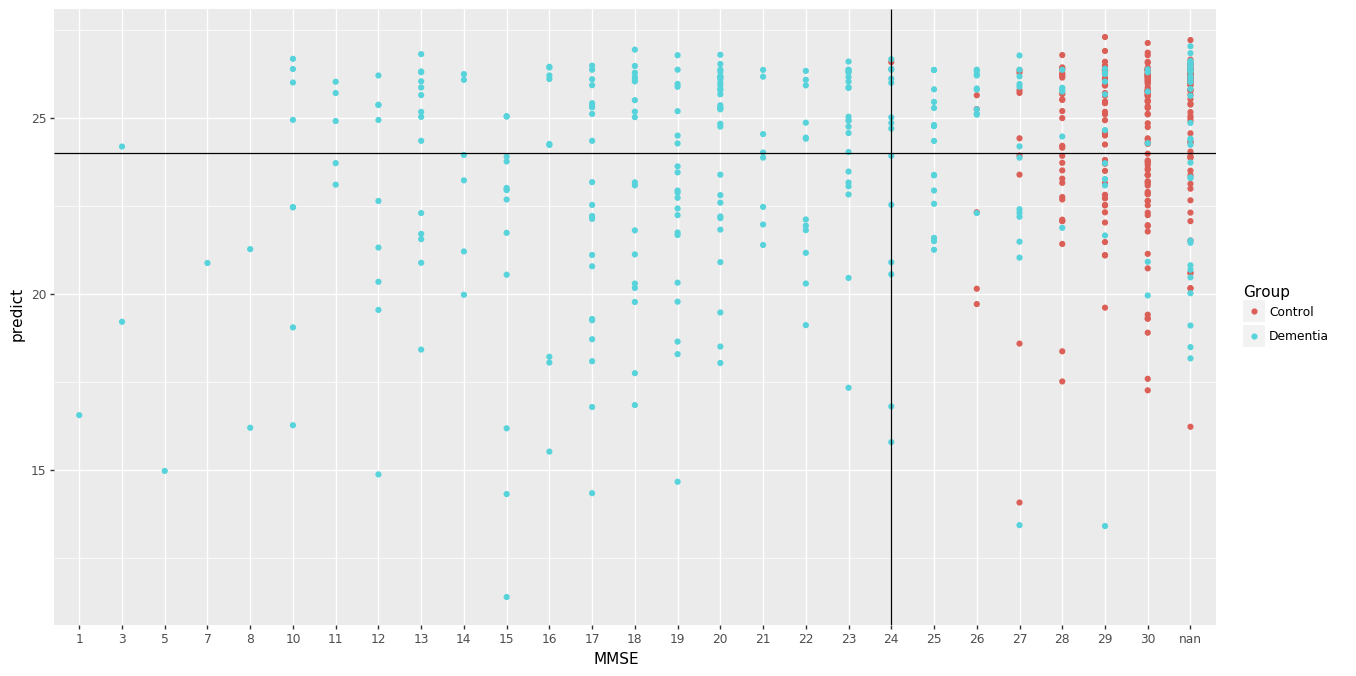

<ggplot: (8741297508458)>

In [322]:
ggplot(meta_pitt) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'Group')) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 20, lty = 2)) + \
theme(figure_size = (15, 8))